In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###Импорты

In [2]:
!pip install tensorflow_datasets
!pip install -U tensorflow-text

     |████████████████████████████████| 4.9 MB 4.3 MB/s 


In [3]:
!pip install pickle5

     |████████████████████████████████| 256 kB 4.2 MB/s 


In [4]:
import collections
import logging
import os
import pathlib
import re
import string
import sys
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow_text as text
import tensorflow as tf
from tqdm.autonotebook import tqdm
tf.compat.v1.enable_eager_execution()
#import pickle5 as pickle
import pickle
import random
import codecs

In [5]:
tf.executing_eagerly()

True

In [6]:
logging.getLogger('tensorflow').setLevel(logging.ERROR)  # suppress warnings

#Токенизация

##Класс токенизатора

###MultigrammTokenizer

In [7]:
class MultigrammTokenizer:
    def __init__(self, num=444):
        self.vocab = {}
        self.devoc = {}
        self.last_token = 2
        self.vocab_size = 2
        self.start_voc = []
        self.gramms = []
        self.make_start_vocab(num)
        self.start_token = 1
        self.end_token = 2
        self.start_num = num

    def make_start_vocab(self, num):
        self.start_voc.append(-1)
        self.gramms.append([-1])
        curr_vok = {"num": 0, "token": self.giveNT(), "vocab": {}, "empty": False}
        self.devoc[curr_vok["token"]] = {"num": 0, "gramm": [-1]}
        self.vocab[-1] = curr_vok
        for i in range(num):
            self.start_voc.append(i)
            self.gramms.append([i])
            curr_vok = {"num": 0, "token": self.giveNT(), "vocab": {}, "empty": False}
            self.devoc[curr_vok["token"]] = {"num": 0, "gramm": [i]}
            self.vocab[i] = curr_vok

    def giveNT(self):
        self.last_token += 1
        self.vocab_size += 1
        return self.last_token

    def adopt(self, texts, vocab_size=2000, ad_num=False, num_cycles=10, part_add=0.25,
              show_main=False, show_NGW=True, min_len=0):
        """


        :param min_len:
        :param show_NGW:
        :param show_main:
        :param part_add:
        :param texts: Corpus of texts, on which we will make tokenizer
        :param vocab_size: Aim of vocab size
        :param ad_num: Boolean, if True, then adding new "words" will be repeated exact number of times (num)
                                if False, then adding will continue, while vocab is not filled
        :param num_cycles: Number of adding cycles
        :return: Nothing
        """
        # str_texts = []
        # for text in texts:
        #    curr_text = text.copy()
        #    curr_text = ",".join(list(curr_text.astype(str)))
        #    str_texts.append(curr_text)
        # self.count_start(texts)
        if show_main:

            if ad_num:
                for i in tqdm(range(num_cycles)):
                    self.adopt_onse(texts, part_add, show=show_NGW, min_len=min_len)
            else:
                while self.vocab_size < vocab_size:
                    self.adopt_onse(texts, part_add, show=show_NGW, min_len=min_len)
        else:
            if ad_num:
                for i in range(num_cycles):
                    self.adopt_onse(texts, part_add, show=show_NGW, min_len=min_len)
            else:
                while self.vocab_size < vocab_size:
                    self.adopt_onse(texts, part_add, show=show_NGW, min_len=min_len)

    def count_start(self, texts):
        keys = self.vocab.keys()
        for key in keys:
            self.vocab[key]["num"] = 0
        for text in texts:
            unique, counts = np.unique(text, return_counts=True)
            for i in range(len(unique)):
                self.vocab[unique[i]]["num"] += counts[i]
                token = self.vocab[unique[i]]["token"]
                self.devoc[token]["num"] += counts[i]

    def adopt_onse(self, texts, part_add=0.25, show=True, min_len=0):
        NG = self.makeNGW(texts, show)
        i = 0
        start_len = self.vocab_size
        while (i < int(start_len * part_add)) and (i < len(NG)):
            self.adopt_NG(NG[i][1], NG[i][0])
            i += 1
        for key in self.devoc.keys():
            self.devoc[key]["num"] = 0
        for text in texts:
            tokened = self.tokenize(text)
            for token in tokened[1:-1]:
                self.devoc[token]["num"] += 1
        self.rebalance(border = min_len)

    def rebalance(self, border=0):
        old_devoc = self.devoc.copy()
        old_voc_size = self.vocab_size
        self.vocab = {}
        self.devoc = {}
        self.last_token = 2
        self.vocab_size = 2
        self.start_voc = []
        self.gramms = []
        self.make_start_vocab(self.start_num)
        self.start_token = 1
        self.end_token = 2
        ind = 3
        while ind <= old_voc_size:
            curr_num = old_devoc[ind]["num"]
            curr_gramm = old_devoc[ind]["gramm"]
            if (curr_num > border) and (len(curr_gramm) > 1):
                self.adopt_NG(curr_gramm, curr_num)
            elif len(curr_gramm) == 1:
                self.vocab[curr_gramm[0]]["num"] = curr_num
                self.devoc[self.vocab[curr_gramm[0]]["token"]]["num"] = curr_num

            ind += 1

    def makeNGW(self, texts, show):
        """
        Make cortege-array of new grams with their freq
        """

        tokened = []
        for i in range(len(texts)):
            tokened.append(self.tokenize(texts[i])[1:-1])
        new_gramms = {}
        if show:
            for key_1 in tqdm(self.devoc.keys()):
                for key_2 in self.devoc.keys():
                    gramm1 = self.devoc[key_1]["gramm"].copy()
                    gramm2 = self.devoc[key_2]["gramm"].copy()
                    curr_gramm = gramm1 + gramm2
                    if not (curr_gramm in self.gramms):
                        if int(key_1) in new_gramms:
                            new_gramms[int(key_1)][int(key_2)] = {"num": 0, "gramm": curr_gramm}
                        else:
                            new_gramms[int(key_1)] = {}
                            new_gramms[int(key_1)][int(key_2)] = {"num": 0, "gramm": curr_gramm}
        else:
            for key_1 in self.devoc.keys():
                for key_2 in self.devoc.keys():
                    gramm1 = self.devoc[key_1]["gramm"].copy()
                    gramm2 = self.devoc[key_2]["gramm"].copy()
                    curr_gramm = gramm1 + gramm2
                    if not (curr_gramm in self.gramms):
                        if int(key_1) in new_gramms:
                            new_gramms[int(key_1)][int(key_2)] = {"num": 0, "gramm": curr_gramm}
                        else:
                            new_gramms[int(key_1)] = {}
                            new_gramms[int(key_1)][int(key_2)] = {"num": 0, "gramm": curr_gramm}
        for i in range(len(tokened)):
            for ind in range(1, len(tokened[i])):
                tok1 = tokened[i][ind - 1]
                tok2 = tokened[i][ind]
                try:
                    new_gramms[tok1][tok2]["num"] += 1
                except:
                    print(tok1)
                    print(tok2)
                    print(self.devoc[tok1]["gramm"].copy())
                    print(self.devoc[tok2]["gramm"].copy())
                    a = self.devoc[tok1]["gramm"].copy() + self.devoc[tok2]["gramm"].copy()
                    print(a)
                    print(a in self.gramms)
                    print(texts[i])
                    print(i)
                    new_gramms[tok1][tok2]["num"] += 1
        ngrams = []
        for key_1 in new_gramms.keys():
            for key_2 in new_gramms[key_1].keys():
                ngrams.append((new_gramms[key_1][key_2]["num"], new_gramms[key_1][key_2]["gramm"]))
        ngrams = sorted(ngrams, reverse=True)

        # ngrams = []
        # for gramm in tqdm(self.gramms):
        #    for gramm1 in self.gramms:
        #        curr_gramm = gramm.copy()
        #        curr_gramm_1 = gramm1.copy()
        #        curr_gramm = curr_gramm + curr_gramm_1
        #        if curr_gramm in self.gramms:
        #            pass
        #        else:
        #            curr_num = self.count_freq(curr_gramm, str_texts)
        #            ngrams.append((curr_num, curr_gramm))
        # ngrams = sorted(ngrams, reverse=True)

        return ngrams

    def adopt_NG(self, gramm, num):
        """
        Add new gramm to self.vocab (with num)
        """

        curr_path = self.vocab
        if len(gramm) < 2:
            print(gramm)
            print("Фигня с граммой")
        else:

            i = 0
            last_token = self.last_token + 1
            while i < len(gramm):
                if gramm[i] in curr_path:
                    if i == (len(gramm) - 1):
                        if curr_path[gramm[i]]["empty"]:
                            token = self.giveNT()
                            curr_path[gramm[i]]["num"] = num
                            curr_path[gramm[i]]["token"] = token
                            curr_path[gramm[i]]["empty"] = False
                            self.gramms.append(gramm)
                            self.devoc[token] = {"num": num, "gramm": gramm}
                    else:
                        last_token = curr_path[gramm[i]]["token"]
                        curr_path = curr_path[gramm[i]]["vocab"]
                else:
                    if i == (len(gramm) - 1):
                        token = self.giveNT()
                        curr_voc = {"num": num, "token": token, "vocab": {}, "empty": False}
                        curr_path[gramm[i]] = curr_voc
                        self.gramms.append(gramm)
                        self.devoc[token] = {"num": num, "gramm": gramm}
                    else:
                        curr_voc = {"num": 0, "token": last_token, "vocab": {}, "empty": True}
                        curr_path[gramm[i]] = curr_voc
                        curr_path = curr_path[gramm[i]]["vocab"]
                i += 1

    def count_freq(self, gramm, str_texts):
        """
        Count freq of current ngramm
        """
        num = 0
        curr_gramm = gramm.copy()
        curr_gramm = ",".join(np.array(curr_gramm).astype(str))
        for text in str_texts:
            num += text.count(curr_gramm)

        return num

    def tokenize(self, text, make_drop=False, prob=0.001):
        ind = 0
        res_mass = [self.start_token]
        if len(text) > 0:

            curr_voc = self.vocab[text[0]]
            forw_ind = ind
            forw_voc = curr_voc
            in_empty = False
            while ind + 1 < len(text):
                if in_empty:
                    if forw_ind + 2 == len(text):
                        if text[forw_ind + 1] in forw_voc["vocab"]:
                            if forw_voc["vocab"][text[forw_ind + 1]]["empty"]:
                                in_empty = False
                                curr_token = int(curr_voc["token"])
                                if curr_voc["empty"]:
                                    print("Добавляем проблемный токен")
                                res_mass = self.correct_add(res_mass.copy(), curr_token, make_drop, prob)
                                # res_mass.append(curr_token)
                                curr_voc = self.vocab[text[ind + 1]]
                                ind += 1
                            else:
                                curr_token = int(forw_voc["vocab"][text[forw_ind + 1]]["token"])
                                res_mass.append(curr_token)
                                curr_voc = self.vocab[text[forw_ind + 1]]
                                ind = forw_ind + 1
                        else:
                            in_empty = False
                            curr_token = int(curr_voc["token"])
                            if curr_voc["empty"]:
                                print("Добавляем проблемный токен")
                            res_mass = self.correct_add(res_mass.copy(), curr_token, make_drop, prob)
                            # res_mass.append(curr_token)
                            curr_voc = self.vocab[text[ind + 1]]
                            ind += 1
                    else:
                        if text[forw_ind + 1] in forw_voc["vocab"]:
                            if forw_voc["vocab"][text[forw_ind + 1]]["empty"]:
                                forw_voc = forw_voc["vocab"][text[forw_ind + 1]]
                                forw_ind += 1
                            else:
                                curr_voc = forw_voc["vocab"][text[forw_ind + 1]]
                                ind = forw_ind + 1
                                in_empty = False
                        else:
                            in_empty = False
                            curr_token = int(curr_voc["token"])
                            if curr_voc["empty"]:
                                print("Добавляем проблемный токен")
                            res_mass = self.correct_add(res_mass.copy(), curr_token, make_drop, prob)
                            # res_mass.append(curr_token)
                            curr_voc = self.vocab[text[ind + 1]]
                            ind += 1
                            if ind + 1 == len(text):
                                curr_token = int(curr_voc["token"])
                                if curr_voc["empty"]:
                                    print("Добавляем проблемный токен")
                                res_mass = self.correct_add(res_mass.copy(), curr_token, make_drop, prob)
                            # res_mass.append(curr_token)
                else:
                    if text[ind + 1] in curr_voc["vocab"]:
                        if curr_voc["vocab"][text[ind + 1]]["empty"]:
                            if ind + 2 == len(text):
                                curr_token = int(curr_voc["token"])
                                if curr_voc["empty"]:
                                    print("Добавляем проблемный токен")
                                res_mass = self.correct_add(res_mass.copy(), curr_token, make_drop, prob)
                                # res_mass.append(curr_token)
                                curr_voc = self.vocab[text[ind + 1]]
                                ind += 1
                                curr_token = int(curr_voc["token"])
                                if curr_voc["empty"]:
                                    print("Добавляем проблемный токен")
                                res_mass = self.correct_add(res_mass.copy(), curr_token, make_drop, prob)
                                # res_mass.append(curr_token)
                            else:

                                in_empty = True
                                forw_voc = curr_voc["vocab"][text[ind + 1]]
                                forw_ind = ind + 1
                        else:
                            if ind + 2 == len(text):
                                curr_voc = curr_voc["vocab"][text[ind + 1]]
                                ind += 1
                                curr_token = int(curr_voc["token"])
                                if curr_voc["empty"]:
                                    print("Добавляем проблемный токен")
                                res_mass = self.correct_add(res_mass.copy(), curr_token, make_drop, prob)
                                # res_mass.append(curr_token)
                            else:
                                curr_voc = curr_voc["vocab"][text[ind + 1]]
                                ind += 1

                    else:
                        if ind + 2 == len(text):
                            curr_token = int(curr_voc["token"])
                            if curr_voc["empty"]:
                                print("Добавляем проблемный токен")
                            res_mass = self.correct_add(res_mass.copy(), curr_token, make_drop, prob)
                            # res_mass.append(curr_token)
                            curr_voc = self.vocab[text[ind + 1]]
                            ind += 1
                            curr_token = int(curr_voc["token"])
                            if curr_voc["empty"]:
                                print("Добавляем проблемный токен")
                            res_mass = self.correct_add(res_mass.copy(), curr_token, make_drop, prob)
                            # res_mass.append(curr_token)
                        else:
                            curr_token = int(curr_voc["token"])
                            if curr_voc["empty"]:
                                print("Добавляем проблемный токен")
                            res_mass = self.correct_add(res_mass.copy(), curr_token, make_drop, prob)
                            # res_mass.append(curr_token)
                            curr_voc = self.vocab[text[ind + 1]]
                            ind += 1

        res_mass.append(self.end_token)
        return res_mass

    def correct_add(self, curr_mass, new_token, make_drop, prob):
        if make_drop:
            curr_prob = random.random()
            if curr_prob < prob:
                gramm = self.devoc[new_token]["gramm"]
                for ind in gramm:
                    curr_mass.append(self.vocab[ind]["token"])
                return curr_mass.copy()
            else:
                curr_mass.append(new_token)
                return curr_mass.copy()
        else:
            curr_mass.append(new_token)
            return curr_mass.copy()

    def detokenize(self, text, string=False):
        res_mass = []
        text = text[1:-1]
        for i in range(len(text)):
            res_mass = res_mass + self.devoc[text[i]]["gramm"]
        if string:
            return " ".join(np.array(res_mass).astype("str"))
        else:
            return np.array(res_mass)

    def sorted_devoc(self, num_print=-1):
        d1 = []
        if num_print == -1:
            num_print = len(self.devoc)
        for key in self.devoc.keys():
            d1.append([self.devoc[key]["num"], key, self.devoc[key]["gramm"]])
        d1 = sorted(d1, reverse=True)
        for i in range(min(len(d1), num_print)):
            print("token: " + str(d1[i][1]) + " num: " + str(d1[i][0]) + " gramm: " + str(d1[i][2]))
        return d1

    def save(self, foldername):

        with open(foldername + '/vocab.pickle', 'wb') as handle:
            pickle.dump(self.vocab, handle, protocol=pickle.HIGHEST_PROTOCOL)

        with open(foldername + '/devoc.pickle', 'wb') as handle:
            pickle.dump(self.devoc, handle, protocol=pickle.HIGHEST_PROTOCOL)

        file = open(foldername + '/info.txt', "w")
        if self.last_token != self.vocab_size:
            print("self.last_token!=self.vocab_size")
        file.write(str(self.last_token))
        file.close()

        with open(foldername + '/startvoc.txt', "wb") as fp:  # Pickling
            pickle.dump(self.start_voc, fp)

        with open(foldername + '/gramms.txt', "wb") as fp:  # Pickling
            pickle.dump(self.gramms, fp)

    def load(self, foldername):
        with open(foldername + '/vocab.pickle', 'rb') as handle:
            self.vocab = pickle.load(handle)

        with open(foldername + '/devoc.pickle', 'rb') as handle:
            self.devoc = pickle.load(handle)

        file = open(foldername + '/info.txt', "r")
        self.last_token = int(float(file.readline()))
        self.vocab_size = self.last_token
        file.close()

        with open(foldername + '/startvoc.txt', "rb") as fp:  # Unpickling
            self.start_voc = pickle.load(fp)

        with open(foldername + '/gramms.txt', "rb") as fp:  # Unpickling
            self.gramms = pickle.load(fp)

###RusConverter

In [8]:
class RusConverter():
    def __init__(self):
        self.totok = {}
        self.detok = {}
        self.last_ind = -1

    def adopt(self, vocab_set):
        """
        Make totok and detok, using set of letters.
        :param vocab_set: set of letters
        :return: None
        """
        mass = vocab_set.copy()
        mass = list(mass)
        for i in range(len(mass)):
            self.totok[mass[i]] = self.last_ind + 1
            self.detok[self.last_ind + 1] = mass[i]
            self.last_ind += 1

    def convert(self, text):
        curr_text = text
        curr_text = list(curr_text)
        curr_mass = []
        for i in range(len(curr_text)):
            if curr_text[i] in self.totok:
                curr_mass.append(self.totok[curr_text[i]])
        return curr_mass

    def deconvert(self, mass):
        curr_mass = mass.copy()
        curr_text = []
        for i in range(len(curr_mass)):
            curr_text.append(self.detok[curr_mass[i]])
        curr_text = "".join(curr_text)
        return curr_text

    def print_top(self, print_mass):
        for i in range(len(print_mass)):
            if print_mass[i][2] != [-1]:
                print("num: " + "%6d" % print_mass[i][0] + " gramm:  " +
                    self.deconvert(print_mass[i][2]))

    def save(self, foldername):

        with open(foldername + '/totok.pickle', 'wb') as handle:
            pickle.dump(self.totok, handle, protocol=pickle.HIGHEST_PROTOCOL)

        with open(foldername + '/detok.pickle', 'wb') as handle:
            pickle.dump(self.detok, handle, protocol=pickle.HIGHEST_PROTOCOL)

        file = open(foldername + '/conv_info.txt', "w")
        file.write(str(self.last_ind))
        file.close()

    def load(self, foldername):
        with open(foldername + '/totok.pickle', 'rb') as handle:
            self.totok = pickle.load(handle)

        with open(foldername + '/detok.pickle', 'rb') as handle:
            self.detok = pickle.load(handle)

        file = open(foldername + '/conv_info.txt', "r")
        self.last_ind = int(float(file.readline()))
        file.close()


###LangTokenizer

In [9]:
class LangTokenizer:
    def __init__(self, vocab=None):
        if vocab is None:
            vocab = set([])
        if type(vocab)!=type(set([])):
            print("Словарь не сет")

        self.converter = RusConverter()
        self.converter.adopt(vocab)
        self.tokenizer = MultigrammTokenizer(num=(self.converter.last_ind+1))

    def adopt(self, texts, vocab_size=2000, ad_num=False, num_cycles=10, part_add=0.25,
              show_main=False, show_NGW=True):
        ind_texts = []
        for curr_str in texts:
            ind_texts.append(self.converter.convert(curr_str))

        self.tokenizer.adopt(ind_texts, vocab_size=vocab_size, ad_num=ad_num, num_cycles=num_cycles, part_add=part_add,
              show_main=show_main, show_NGW=show_NGW)

    def tokenize(self, text, make_drop=False, prob=0.001):
        ind_text = self.converter.convert(text)
        return self.tokenizer.tokenize(ind_text, make_drop=make_drop, prob=prob)

    def detokenize(self, text):
        ind_text = self.tokenizer.detokenize(text)
        return self.converter.deconvert(ind_text)

    def save(self, foldername):
        self.converter.save(foldername)
        self.tokenizer.save(foldername)

    def load(self, foldername):
        self.converter.load(foldername)

        self.tokenizer = MultigrammTokenizer(num=(self.converter.last_ind+1))
        self.tokenizer.load(foldername)

#Подготовка данных

##Загрузка

In [10]:
def load_data(path):
  text = path.read_text(encoding='utf-8')

  lines = text.splitlines()
  pairs = [line.split('\t') for line in lines]

  inp = [inp for targ, inp in pairs]
  targ = [targ for targ, inp in pairs]

  return targ, inp

def load_data_from_file(frequency):
  with open("/content/drive/My Drive/Colab Notebooks/Mentoring2122/rus-eng/rus.txt", 'r') as f:
    inp = []
    targ = []
    i = 0
    for line in f:
      i+=1
      if(i>frequency):
        i = 0
        #print(line)
        inp.append(line.split('\t')[0])
        #print(line.split('\t')[0])
        #print(line.split('\t')[1])
        tg = line.split('\t')[1]
        targ.append(tg)

    return targ, inp

In [11]:
inp, targ = load_data_from_file(0)

In [12]:
def make_rus_text():
  with open("/content/drive/My Drive/Colab Notebooks/Mentoring2122/Transformer/rus-eng.txt", "w") as file:
    for i in tqdm(range(len(targ))):
      line = inp[i] + "_" + targ[i]+'\n'
      #print(line)
      file.write(line)

In [13]:
make_rus_text()

  0%|          | 0/431097 [00:00<?, ?it/s]

In [14]:
def make_pair(example):
  examples = tf.strings.split(example, sep="_")
  return examples[0], examples[1]
  #return example, example

lines_dataset = tf.data.TextLineDataset("/content/drive/My Drive/Colab Notebooks/Mentoring2122/Transformer/rus-eng.txt")
labeled_dataset = lines_dataset.map(lambda ex: make_pair(ex))
#only_rus = lines_dataset.map(lambda ex: make_pair(ex)[0])
#only_en = lines_dataset.map(lambda ex: make_pair(ex)[1])
#labeled_data_sets.append(labeled_dataset)

In [15]:
BUFFER_SIZE = 50000
BATCH_SIZE = 64
VALIDATION_SIZE = 5000

In [16]:
all_labeled_data = labeled_dataset.shuffle(
    BUFFER_SIZE, reshuffle_each_iteration=False, )

In [17]:
train_examples = all_labeled_data.skip(VALIDATION_SIZE).shuffle(BUFFER_SIZE).prefetch(BUFFER_SIZE)
val_examples = all_labeled_data.take(VALIDATION_SIZE).prefetch(BUFFER_SIZE).prefetch(BUFFER_SIZE)

In [18]:
type(train_examples)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

In [19]:
for rus_examples, en_examples in train_examples.batch(3).take(1):
  for rus in rus_examples.numpy():
    print(rus.decode('utf-8'))

  print()

  for en in en_examples.numpy():
    print(en.decode('utf-8'))

Как скажете.
Наш воздух загрязнён.
Том был обаятелен.

Whatever you say.
Our air is polluted.
Tom was charming.


##Русская токенизация

###Создание нового токенизатора

In [20]:
rus_list_lines = []
rus_lines = []
eng_list_lines = []
eng_lines = []
rus_bad_symb = ['\xa0', '\u200b','\u202f']
eng_bad_symb = ['\xa0']
path = "/content/drive/My Drive/Colab Notebooks/Mentoring2122/Transformer/rus-eng.txt"
with codecs.open(path, encoding='utf-8') as fin:
    for line in fin:
        rus_curr = line[:-2].lower().split("_")[0]
        rus_curr_list = list(rus_curr)
        eng_curr = line[:-2].lower().split("_")[1]
        eng_curr_list = list(eng_curr)
        
        for symb in rus_bad_symb:
            while symb in rus_curr_list:
                rus_curr_list.remove(symb)
        rus_lines.append("".join(rus_curr_list))
        rus_list_lines.append(rus_curr_list)
        
        
        for symb in eng_bad_symb:
            while symb in eng_curr_list:
                eng_curr_list.remove(symb)
        eng_lines.append("".join(eng_curr_list))
        eng_list_lines.append(eng_curr_list)
        
rus_vocab = set([])
eng_vocab = set([])

for curr_list in rus_list_lines:
    rus_vocab = rus_vocab.union(curr_list)
    
for curr_list in eng_list_lines:
    eng_vocab = eng_vocab.union(curr_list)

print(rus_vocab)
print(len(rus_vocab))
print("---")
print(eng_vocab)
print(len(eng_vocab))

{'n', '0', 'h', 'ж', '7', 'ь', '4', ',', 'б', 'й', 'ъ', '9', '/', '5', '(', 'в', 'ó', 'е', 's', 'i', 'п', 'v', 'г', 'ю', 'g', '’', 'l', '+', 'м', 'н', 'ф', 'a', '‽', '»', '―', 'р', '–', ' ', '8', 'r', 'q', '₂', 'y', '$', 'f', ')', 'b', 'd', 'и', 'э', 'к', '«', '1', ':', '3', 't', '°', '№', '!', 'ё', 'u', '́', 'z', 'т', '"', 'д', 'ч', 'с', 'я', '-', '6', 'л', 'p', '…', 'k', '@', 'х', 'o', '%', '?', ';', 'ы', 'а', 'з', 'ц', 'о', 'x', 'c', 'e', '.', "'", 'ш', 'щ', '2', 'm', 'у', 'j', 'w', '—'}
99
---
{'n', 'h', '0', '7', '4', ',', '9', '/', 'ã', '5', 's', 'i', 'v', 'g', '’', 'l', '+', 'ï', 'a', 'r', ' ', 'q', '8', '₂', 'ú', 'ê', 'y', '$', 'f', 'b', 'd', 'ׁ', '1', 'é', ':', '3', 'ö', 't', '°', 'ü', '‘', '!', 'u', 'z', '"', 'k', 'p', '@', '6', 'o', '%', 'º', '?', ';', '—', '€', 'x', 'c', 'e', '.', '&', 'î', "'", 'm', '2', 'j', 'w', '-'}
68


In [21]:
rus_tokenizer = LangTokenizer(vocab=rus_vocab)
eng_tokenizer = LangTokenizer(vocab=eng_vocab)

In [22]:
#rus_tokenizer.adopt(rus_lines, ad_num=True, num_cycles=5, part_add = 0.50, show_main = True, show_NGW = False)

In [23]:
#eng_tokenizer.adopt(eng_lines, ad_num=True, num_cycles=5, part_add = 0.50, show_main = True, show_NGW = False)

In [24]:
path = '/content/drive/My Drive/Colab Notebooks/Mentoring2122/Transformer/Tokenizers/'
#rus_tokenizer.save(path+"RT1")
#eng_tokenizer.save(path+"EN1")

###Встраивание токенизатора

In [25]:
rus_tokenizer = LangTokenizer()
eng_tokenizer = LangTokenizer()
path = '/content/drive/My Drive/Colab Notebooks/Mentoring2122/Transformer/Tokenizers/'
rus_tokenizer.load(path+"RT1")
eng_tokenizer.load(path+"EN1")

In [26]:
rus_tokenizer.tokenizer.vocab_size + 1

769

In [27]:
for rus in rus_examples.numpy():
    print(rus.decode('utf-8'))
    print(rus_tokenizer.tokenize(rus.decode('utf-8')))

Как скажете.
[1, 438, 110, 149, 288, 189, 2]
Наш воздух загрязнён.
[1, 699, 611, 7, 201, 55, 407, 30, 422, 7, 43, 47, 505, 2]
Том был обаятелен.
[1, 107, 686, 160, 49, 325, 142, 134, 94, 2]


In [28]:
for eng in en_examples.numpy():
    print(eng.decode('utf-8'))
    print(eng_tokenizer.tokenize(eng.decode('utf-8')))

Whatever you say.
[1, 89, 132, 154, 116, 93, 180, 68, 2]
Our air is polluted.
[1, 270, 80, 250, 182, 49, 226, 61, 56, 132, 25, 68, 2]
Tom was charming.
[1, 82, 254, 159, 112, 17, 109, 68, 2]


In [29]:
tens1 = en_examples

In [30]:
A = tens1.numpy()[1].decode("utf-8")
print(A)
#rus_tokenizer.texts_to_sequences([A])[0]
print(A.encode("utf-8"))

Our air is polluted.
b'Our air is polluted.'


In [31]:
def rus_tokenize(text_batch, make_drop=True):
  try:
    text_batch.numpy()
  except:
    print(type(text_batch))
    print("rt")
    my_tens = text_batch
    print(text_batch)
  new = []
  max_len = 0
  for line in text_batch.numpy():
    curr = rus_tokenizer.tokenize((line.decode("utf-8")).lower(), make_drop=make_drop)
    new.append(curr)
    if len(curr) > max_len:
      max_len = len(curr)
  for i in range(len(new)):
    while(len(new[i])<max_len):
      new[i].append(0)
    new[i] = tf.cast(new[i] , tf.int64)
    
  return tf.convert_to_tensor(new)


def rus_detokenize(text_batch):
  try:
    text_batch.numpy()
  except:
    print("dt")
  np_tb = text_batch.numpy()
  new = []
  for i in range(np_tb.shape[0]):
    curr = list(np_tb[i])
    while(curr[-1]==0):
      curr.pop(-1)
    new.append(rus_tokenizer.detokenize(curr))
  new = np.array(new)
  return tf.convert_to_tensor(new)


def en_tokenize(text_batch, make_drop=True):
  try:
    text_batch.numpy()
  except:
    print("et")
  new = []
  max_len = 0
  for line in text_batch.numpy():
    curr = eng_tokenizer.tokenize((line.decode("utf-8")).lower(), make_drop=make_drop)
    new.append(curr)
    
    if len(curr) > max_len:
      max_len = len(curr)
  for i in range(len(new)):
    while(len(new[i])<max_len):
      new[i].append(0)
    new[i] = tf.cast(new[i] , tf.int64)
    
  return tf.convert_to_tensor(new)


def en_detokenize(text_batch):
  try:
    text_batch.numpy()
  except:
    print("ed")
  #nump_ver = text_batch.numpy().map()
  np_tb = text_batch.numpy()
  new = []
  for i in range(np_tb.shape[0]):
    curr = list(np_tb[i])
    while(curr[-1]==0):
      curr.pop(-1)
    
    new.append(eng_tokenizer.detokenize(curr))
  new = np.array(new)
  return tf.convert_to_tensor(new)
  return tf.convert_to_tensor(new)


print(en_examples)
A = en_tokenize(en_examples)
print(A)
B = en_detokenize(A)
print(B)

tf.Tensor([b'Whatever you say.' b'Our air is polluted.' b'Tom was charming.'], shape=(3,), dtype=string)
tf.Tensor(
[[  1 186  95 257 116  93 180  68   2   0   0   0   0]
 [  1 397  80 250 182  49 226  61  56 132  25  68   2]
 [  1 398 159 112  17 109  68   2   0   0   0   0   0]], shape=(3, 13), dtype=int64)
tf.Tensor([b'whatever you say.' b'our air is polluted.' b'tom was charming.'], shape=(3,), dtype=string)


In [32]:
for rus in rus_examples.numpy():
    print(rus.decode('utf-8'))
    print(rus_tokenizer.tokenize(rus.decode('utf-8')))
A = rus_tokenize(rus_examples)
print(A)
B = rus_detokenize(A)

for rus in B.numpy():
    print(rus.decode('utf-8'))
    print(rus_tokenizer.tokenize(rus.decode('utf-8')))

Как скажете.
[1, 438, 110, 149, 288, 189, 2]
Наш воздух загрязнён.
[1, 699, 611, 7, 201, 55, 407, 30, 422, 7, 43, 47, 505, 2]
Том был обаятелен.
[1, 107, 686, 160, 49, 325, 142, 134, 94, 2]
tf.Tensor(
[[  1 248 110 149 288 189   2   0   0   0   0   0   0   0   0]
 [  1 116  60 611   7 201  55 407  30 422   7  43  47 505   2]
 [  1 684 160  49 325 142 134  94   2   0   0   0   0   0   0]], shape=(3, 15), dtype=int64)
как скажете.
[1, 248, 110, 149, 288, 189, 2]
наш воздух загрязнён.
[1, 116, 60, 611, 7, 201, 55, 407, 30, 422, 7, 43, 47, 505, 2]
том был обаятелен.
[1, 684, 160, 49, 325, 142, 134, 94, 2]


##Маркировка текста

In [33]:
def tokenize_pairs(rus, en):
    rus = tf.py_function(rus_tokenize, [rus], tf.int64)
    # Convert from ragged to dense, padding with zeros.
    #rus = rus.to_tensor()

    en = tf.py_function(en_tokenize, [en], tf.int64)
    # Convert from ragged to dense, padding with zeros.
    #en = en.to_tensor()
    return rus, en

In [34]:
A = train_examples.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [35]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64
tf.executing_eagerly()

True

In [36]:
def make_batches(ds):
  return (
      ds
      .cache()
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(tokenize_pairs, num_parallel_calls=tf.data.AUTOTUNE)
      .prefetch(tf.data.AUTOTUNE))


train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)
print(type(train_batches))

<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>


In [37]:
for rus_examples, en_examples in train_batches.take(1):
  for rus in rus_examples.numpy():
    print(rus)

  print()

  for en in en_examples.numpy():
    print(en)

[  1 290 471 129   4  56 511 149  19   2   0   0   0   0   0   0   0   0
   0]
[  1 320 261 319 264  15 272  94   2   0   0   0   0   0   0   0   0   0
   0]
[  1 188 686 151 343 538 140 258   2   0   0   0   0   0   0   0   0   0
   0]
[  1 154 150  96 151 170 111 134  94   2   0   0   0   0   0   0   0   0
   0]
[  1 749 185 208 148 413   2   0   0   0   0   0   0   0   0   0   0   0
   0]
[  1 221 114 165  37  52 735 162  60 110 183 342   2   0   0   0   0   0
   0]
[  1 161 209 409 230 159 186  99 163   2   0   0   0   0   0   0   0   0
   0]
[  1 154 345  38 115 414 307   2   0   0   0   0   0   0   0   0   0   0
   0]
[  1 154 160  99  47  30  17 229 457   2   0   0   0   0   0   0   0   0
   0]
[  1 536 394 592 379 679  30 195   2   0   0   0   0   0   0   0   0   0
   0]
[  1 178 128 369 467 519 137 303 288 105 556 621   2   0   0   0   0   0
   0]
[  1 178 222 117 315 142 125 160 408  94   2   0   0   0   0   0   0   0
   0]
[  1 584 491 385  83 622  88 244   2   0   0   0   0

In [38]:
for rus_examples, en_examples in train_examples.take(1):
  for rus in rus_examples.numpy():
    print(rus)

  print()

  for en in en_examples.numpy():
    print(en)

208
156
208
189
208
181
32
208
189
209
131
208
182
208
189
208
190
32
208
177
209
139
208
187
208
190
32
208
183
208
189
208
176
209
130
209
140
32
208
191
208
190
209
135
208
181
208
188
209
131
46

73
32
110
101
101
100
101
100
32
116
111
32
107
110
111
119
32
119
104
121
46


#Подготовка модели

##Positional Encoding

In [39]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [40]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)

(1, 2048, 512)


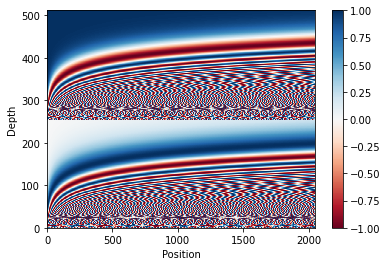

In [41]:
n, d = 2048, 512
pos_encoding = positional_encoding(n, d)
print(pos_encoding.shape)
pos_encoding = pos_encoding[0]

# Juggle the dimensions for the plot
pos_encoding = tf.reshape(pos_encoding, (n, d//2, 2))
pos_encoding = tf.transpose(pos_encoding, (2, 1, 0))
pos_encoding = tf.reshape(pos_encoding, (d, n))

plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

##Masking

In [42]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [43]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

In [44]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

In [45]:
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

##Scaled dot product attention

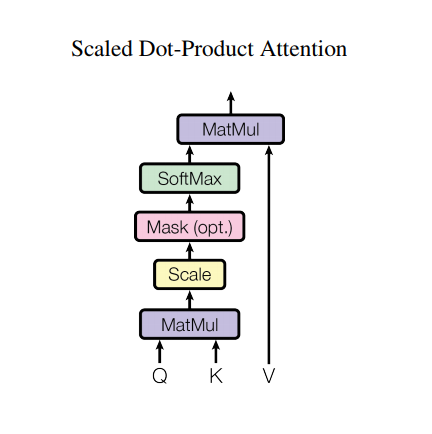

In [46]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead)
  but it must be broadcastable for addition.

  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable
          to (..., seq_len_q, seq_len_k). Defaults to None.

  Returns:
    output, attention_weights
  """

  #print(type(q))
  #print(type(k))
  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

In [47]:
def print_out(q, k, v):
  temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
  print('Attention weights are:')
  print(temp_attn)
  print('Output is:')
  print(temp_out)

In [48]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10, 0, 0],
                      [0, 10, 0],
                      [0, 0, 10],
                      [0, 0, 10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[1, 0],
                      [10, 0],
                      [100, 5],
                      [1000, 6]], dtype=tf.float32)  # (4, 2)

# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [49]:
# This query aligns with a repeated key (third and fourth),
# so all associated values get averaged.
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [50]:
# This query aligns equally with the first and second key,
# so their values get averaged.
temp_q = tf.constant([[10, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)


In [51]:
temp_q = tf.constant([[0, 0, 10],
                      [0, 10, 0],
                      [10, 10, 0]], dtype=tf.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output is:
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


##Multi-Head Attention

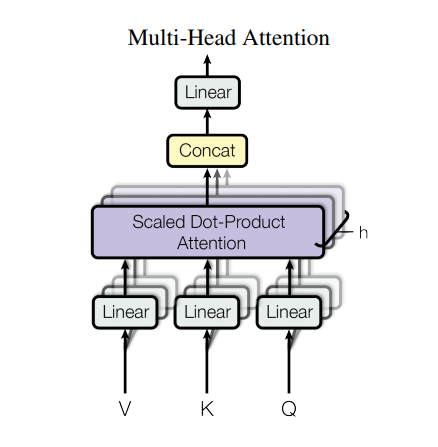

In [52]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)

    self.dense = tf.keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]

    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)

    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

    return output, attention_weights

In [53]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

##Point wise feed forward network

In [54]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [55]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

##Энкодер и декодер

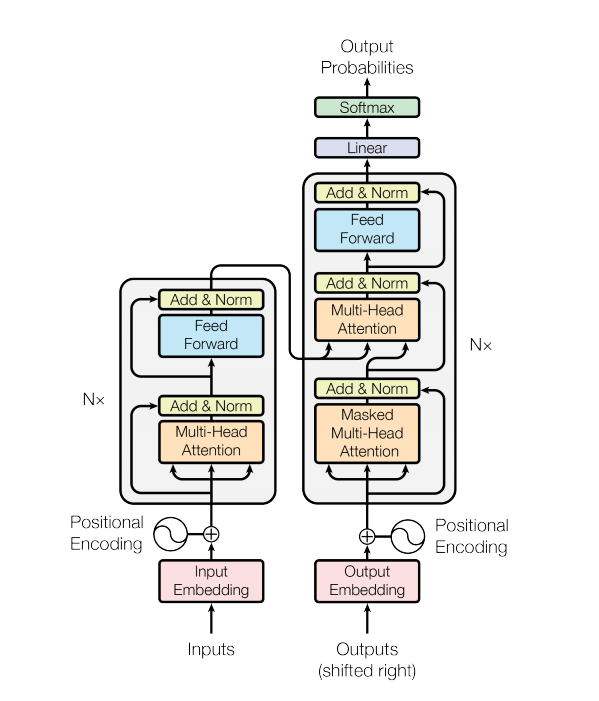

###Энкодер (слой)

In [56]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

    return out2

In [57]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

In [58]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

###Декодер (слой)

In [59]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)

    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

    return out3, attn_weights_block1, attn_weights_block2

In [60]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output,
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

###Энкодер

In [61]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding,
                                            self.d_model)

    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate)
                       for _ in range(num_layers)]

    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]

    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)

    return x  # (batch_size, input_seq_len, d_model)

In [62]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8,
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print(sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


###Декодер

In [63]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}

    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)

      attention_weights[f'decoder_layer{i+1}_block1'] = block1
      attention_weights[f'decoder_layer{i+1}_block2'] = block2

    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

In [64]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8,
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input,
                              enc_output=sample_encoder_output,
                              training=False,
                              look_ahead_mask=None,
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

##Класс трансформера

In [65]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers, d_model, num_heads, dff,
                             input_vocab_size, pe_input, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                           target_vocab_size, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs, training):
    # Keras models prefer if you pass all your inputs in the first argument
    inp, tar = inputs

    enc_padding_mask, look_ahead_mask, dec_padding_mask = self.create_masks(inp, tar)

    

    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)

    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

    return final_output, attention_weights

  def create_masks(self, inp, tar):
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)

    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)

    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    look_ahead_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, look_ahead_mask, dec_padding_mask

In [66]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048,
    input_vocab_size=8500, target_vocab_size=8000,
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer([temp_input, temp_target], training=False)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 36, 8000])

In [67]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

##Оптимизатор

In [68]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [69]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

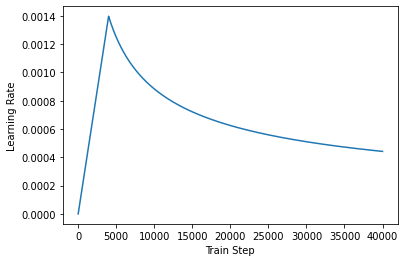

In [70]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

##Loss-функция и метрика

In [71]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [72]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
  accuracies = tf.equal(real, tf.argmax(pred, axis=2))

  mask = tf.math.logical_not(tf.math.equal(real, 0))
  accuracies = tf.math.logical_and(mask, accuracies)

  accuracies = tf.cast(accuracies, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [73]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

#Обучение модели

##Подготовка чекпоинтов

In [74]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=rus_tokenizer.tokenizer.vocab_size + 1,
    target_vocab_size=eng_tokenizer.tokenizer.vocab_size + 1,
    pe_input=1000,
    pe_target=1000,
    rate=dropout_rate)

In [142]:
last = 11
checkpoint_path = "/content/drive/My Drive/Colab Notebooks/Mentoring2122/Transformer/TransToken/checkpoints/train"+str(last)
print(checkpoint_path)
ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest checkpoint restored!!')


#ckpt_save_path = ckpt_manager.save()

/content/drive/My Drive/Colab Notebooks/Mentoring2122/Transformer/TransToken/checkpoints/train11
Latest checkpoint restored!!


In [143]:
EPOCHS = 200

In [144]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]


@tf.function(input_signature=train_step_signature)#, jit_compile = True)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  #tar_inp = tar
  tar_real = tar[:, 1:]
  #tar_real = tar
  #print(tar_inp[0])
  #print(tar_real[0])

  with tf.GradientTape() as tape:
    predictions, _ = transformer([inp, tar_inp],
                                 training = True)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

  train_loss(loss)
  train_accuracy(accuracy_function(tar_real, predictions))

##Обучение

In [145]:
redo = False
#redo = True

if redo:
  name = "/content/drive/My Drive/Colab Notebooks/Mentoring2122/Transformer/TransToken/accuracy.npy"
  np.save(name,np.array([]))
  name = "/content/drive/My Drive/Colab Notebooks/Mentoring2122/Transformer/TransToken/loss.npy"
  np.save(name,np.array([]))
  name = "/content/drive/My Drive/Colab Notebooks/Mentoring2122/Transformer/TransToken/av_accuracy.npy"
  np.save(name,np.array([]))
  name = "/content/drive/My Drive/Colab Notebooks/Mentoring2122/Transformer/TransToken/av_loss.npy"
  np.save(name,np.array([]))
  name = "/content/drive/My Drive/Colab Notebooks/Mentoring2122/Transformer/TransToken/test_accuracy.npy"
  np.save(name,np.array([]))
  name = "/content/drive/My Drive/Colab Notebooks/Mentoring2122/Transformer/TransToken/test_loss.npy"
  np.save(name,np.array([]))

In [9]:
X = []
for i in range(len(loss[59900:])):
  X.append(i//3)

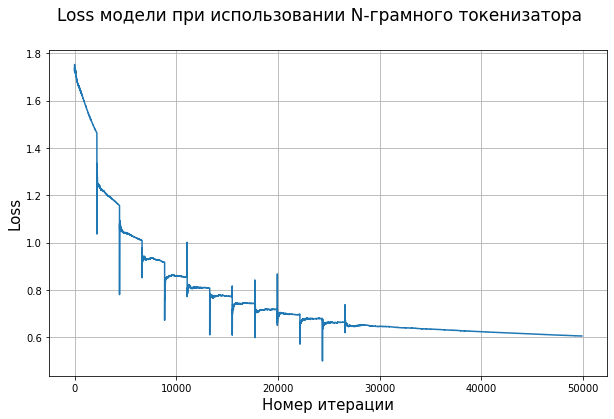

In [22]:
name = "/content/drive/My Drive/Colab Notebooks/Mentoring2122/Transformer/TransToken/loss.npy"
loss = np.load(name)
#print(loss)
plt.figure(figsize=(10, 6))
plt.plot(X, loss[59900:])
plt.ylabel("Loss", fontsize=15)
plt.xlabel("Номер итерации", fontsize=15)
plt.suptitle('Loss модели при использовании N-грамного токенизатора', fontsize=17)
plt.grid()
plt.show()
#np.save(name,np.array([]))
#name = "/content/drive/My Drive/Colab Notebooks/Mentoring2122/Transformer/TransToken/accuracy.npy"
#np.save(name,np.array([]))

In [147]:
#train_loss.reset_states()
#train_accuracy.reset_states()

num_fast_ep = 1

for epoch in tqdm(range(EPOCHS)):
  start = time.time()

  if epoch < num_fast_ep:
    train_loss.reset_states()
    train_accuracy.reset_states()
  # inp -> portuguese, tar -> english

  new_loss = []
  new_accur = []
  epoch_loss = []
  epoch_accur = []
  train_batches = train_batches.shuffle(BUFFER_SIZE)
  for (batch, (inp, tar)) in tqdm(enumerate(train_batches)):
    #print(tar)
    #print(tar[:,:-1])
    train_step(inp, tar)

    
    new_loss = new_loss + [float(train_loss.result())]
    new_accur = new_accur + [float(train_accuracy.result())]
    epoch_loss = epoch_loss + [float(train_loss.result())]
    epoch_accur = epoch_accur + [float(train_accuracy.result())]
    if batch % 50 == 0:
      print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

      name = "/content/drive/My Drive/Colab Notebooks/Mentoring2122/Transformer/TransToken/loss.npy"
      full_loss = np.load(name)
      full_loss = np.array(full_loss.tolist()+new_loss)
      np.save(name,full_loss)
      #print(full_loss)
      new_loss = []
      name = "/content/drive/My Drive/Colab Notebooks/Mentoring2122/Transformer/TransToken/accuracy.npy"
      full_accur = np.load(name)
      full_accur = np.array(full_accur.tolist()+new_accur)
      np.save(name,full_accur)
      new_accur = []
    
    if (batch % 1000 == 0):
      ckpt_save_path = ckpt_manager.save()
      print("---")
      print(f'Saving checkpoint for batch {batch} at {ckpt_save_path}')
      print("---")

  #оценка на тестовой выборке
  test_loss = []
  test_accur = []
  for (batch, (inp, tar)) in tqdm(enumerate(val_batches)):
    tar_inp = tar[:, :-1]
    #tar_inp = tar
    tar_real = tar[:, 1:]
    fn_out, _ = transformer([inp, tar_inp], training=False)

    test_loss.append(loss_function(tar_real, fn_out).numpy())
    test_accur.append(accuracy_function(tar_real, fn_out).numpy())
  test_loss = np.array(test_loss).mean()
  test_accur = np.array(test_accur).mean()
  name = "/content/drive/My Drive/Colab Notebooks/Mentoring2122/Transformer/TransToken/test_loss.npy"
  full_loss = np.load(name)
  full_loss = full_loss.tolist()+[float(test_loss)]
  np.save(name,np.array(full_loss))
  name = "/content/drive/My Drive/Colab Notebooks/Mentoring2122/Transformer/TransToken/test_accuracy.npy"
  full_accur = np.load(name)
  full_accur = full_accur.tolist()+[float(test_accur)]
  np.save(name,np.array(full_accur))

  print(f'Epoch {epoch + 1} Train Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')
  print(f'Epoch {epoch + 1} Test  Loss {test_loss:.4f} Accuracy {test_accur:.4f}')

  if (epoch + 1) % 1 == 0:
    name = "/content/drive/My Drive/Colab Notebooks/Mentoring2122/Transformer/TransToken/av_loss.npy"
    full_loss = np.load(name)
    full_loss = full_loss.tolist()+[np.array(epoch_loss).mean()]
    np.save(name,np.array(full_loss))
    name = "/content/drive/My Drive/Colab Notebooks/Mentoring2122/Transformer/TransToken/av_accuracy.npy"
    full_accur = np.load(name)
    full_accur = full_accur.tolist() + [np.array(epoch_accur).mean()]
    np.save(name,full_accur)
    checkpoint_path = "/content/drive/My Drive/Colab Notebooks/Mentoring2122/Transformer/TransToken/checkpoints/train" + str(epoch)
    ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
    ckpt_save_path = ckpt_manager.save()
    print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')

  

  print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

  0%|          | 0/200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 1 Batch 0 Loss 0.7363 Accuracy 0.7966
---
Saving checkpoint for batch 0 at /content/drive/My Drive/Colab Notebooks/Mentoring2122/Transformer/TransToken/checkpoints/train11/ckpt-104
---
Epoch 1 Batch 50 Loss 0.6651 Accuracy 0.8285
Epoch 1 Batch 100 Loss 0.6683 Accuracy 0.8280
Epoch 1 Batch 150 Loss 0.6497 Accuracy 0.8316
Epoch 1 Batch 200 Loss 0.6519 Accuracy 0.8316
Epoch 1 Batch 250 Loss 0.6570 Accuracy 0.8303
Epoch 1 Batch 300 Loss 0.6549 Accuracy 0.8311
Epoch 1 Batch 350 Loss 0.6547 Accuracy 0.8313
Epoch 1 Batch 400 Loss 0.6592 Accuracy 0.8302
Epoch 1 Batch 450 Loss 0.6563 Accuracy 0.8307
Epoch 1 Batch 500 Loss 0.6539 Accuracy 0.8312
Epoch 1 Batch 550 Loss 0.6530 Accuracy 0.8313
Epoch 1 Batch 600 Loss 0.6550 Accuracy 0.8308
Epoch 1 Batch 650 Loss 0.6568 Accuracy 0.8305
Epoch 1 Batch 700 Loss 0.6528 Accuracy 0.8313
Epoch 1 Batch 750 Loss 0.6511 Accuracy 0.8316
Epoch 1 Batch 800 Loss 0.6500 Accuracy 0.8318
Epoch 1 Batch 850 Loss 0.6484 Accuracy 0.8321
Epoch 1 Batch 900 Loss 0.646

0it [00:00, ?it/s]

Epoch 1 Train Loss 0.6504 Accuracy 0.8318
Epoch 1 Test  Loss 0.4420 Accuracy 0.8815
Saving checkpoint for epoch 1 at /content/drive/My Drive/Colab Notebooks/Mentoring2122/Transformer/TransToken/checkpoints/train0/ckpt-111
Time taken for 1 epoch: 1004.22 secs



0it [00:00, ?it/s]

Epoch 2 Batch 0 Loss 0.6504 Accuracy 0.8317
---
Saving checkpoint for batch 0 at /content/drive/My Drive/Colab Notebooks/Mentoring2122/Transformer/TransToken/checkpoints/train0/ckpt-112
---
Epoch 2 Batch 50 Loss 0.6503 Accuracy 0.8318
Epoch 2 Batch 100 Loss 0.6500 Accuracy 0.8318
Epoch 2 Batch 150 Loss 0.6500 Accuracy 0.8319
Epoch 2 Batch 200 Loss 0.6498 Accuracy 0.8319
Epoch 2 Batch 250 Loss 0.6496 Accuracy 0.8319
Epoch 2 Batch 300 Loss 0.6494 Accuracy 0.8320
Epoch 2 Batch 350 Loss 0.6491 Accuracy 0.8320
Epoch 2 Batch 400 Loss 0.6491 Accuracy 0.8320
Epoch 2 Batch 450 Loss 0.6491 Accuracy 0.8321
Epoch 2 Batch 500 Loss 0.6488 Accuracy 0.8321
Epoch 2 Batch 550 Loss 0.6483 Accuracy 0.8322
Epoch 2 Batch 600 Loss 0.6481 Accuracy 0.8323
Epoch 2 Batch 650 Loss 0.6483 Accuracy 0.8322
Epoch 2 Batch 700 Loss 0.6480 Accuracy 0.8323
Epoch 2 Batch 750 Loss 0.6478 Accuracy 0.8324
Epoch 2 Batch 800 Loss 0.6474 Accuracy 0.8324
Epoch 2 Batch 850 Loss 0.6475 Accuracy 0.8324
Epoch 2 Batch 900 Loss 0.6474

0it [00:00, ?it/s]

Epoch 2 Train Loss 0.6442 Accuracy 0.8333
Epoch 2 Test  Loss 0.4389 Accuracy 0.8818
Saving checkpoint for epoch 2 at /content/drive/My Drive/Colab Notebooks/Mentoring2122/Transformer/TransToken/checkpoints/train1/ckpt-119
Time taken for 1 epoch: 1013.53 secs



0it [00:00, ?it/s]

Epoch 3 Batch 0 Loss 0.6442 Accuracy 0.8333
---
Saving checkpoint for batch 0 at /content/drive/My Drive/Colab Notebooks/Mentoring2122/Transformer/TransToken/checkpoints/train1/ckpt-120
---
Epoch 3 Batch 50 Loss 0.6440 Accuracy 0.8333
Epoch 3 Batch 100 Loss 0.6438 Accuracy 0.8333
Epoch 3 Batch 150 Loss 0.6438 Accuracy 0.8333
Epoch 3 Batch 200 Loss 0.6436 Accuracy 0.8334
Epoch 3 Batch 250 Loss 0.6435 Accuracy 0.8334
Epoch 3 Batch 300 Loss 0.6434 Accuracy 0.8334
Epoch 3 Batch 350 Loss 0.6433 Accuracy 0.8334
Epoch 3 Batch 400 Loss 0.6433 Accuracy 0.8335
Epoch 3 Batch 450 Loss 0.6432 Accuracy 0.8335
Epoch 3 Batch 500 Loss 0.6429 Accuracy 0.8336
Epoch 3 Batch 550 Loss 0.6427 Accuracy 0.8336
Epoch 3 Batch 600 Loss 0.6426 Accuracy 0.8336
Epoch 3 Batch 650 Loss 0.6426 Accuracy 0.8336
Epoch 3 Batch 700 Loss 0.6425 Accuracy 0.8336
Epoch 3 Batch 750 Loss 0.6426 Accuracy 0.8336
Epoch 3 Batch 800 Loss 0.6425 Accuracy 0.8336
Epoch 3 Batch 850 Loss 0.6423 Accuracy 0.8337
Epoch 3 Batch 900 Loss 0.6422

0it [00:00, ?it/s]

Epoch 3 Train Loss 0.6388 Accuracy 0.8345
Epoch 3 Test  Loss 0.4386 Accuracy 0.8821
Saving checkpoint for epoch 3 at /content/drive/My Drive/Colab Notebooks/Mentoring2122/Transformer/TransToken/checkpoints/train2/ckpt-127
Time taken for 1 epoch: 985.50 secs



0it [00:00, ?it/s]

Epoch 4 Batch 0 Loss 0.6388 Accuracy 0.8345
---
Saving checkpoint for batch 0 at /content/drive/My Drive/Colab Notebooks/Mentoring2122/Transformer/TransToken/checkpoints/train2/ckpt-128
---
Epoch 4 Batch 50 Loss 0.6386 Accuracy 0.8346
Epoch 4 Batch 100 Loss 0.6386 Accuracy 0.8346
Epoch 4 Batch 150 Loss 0.6385 Accuracy 0.8346
Epoch 4 Batch 200 Loss 0.6384 Accuracy 0.8346
Epoch 4 Batch 250 Loss 0.6383 Accuracy 0.8347
Epoch 4 Batch 300 Loss 0.6382 Accuracy 0.8347
Epoch 4 Batch 350 Loss 0.6381 Accuracy 0.8347
Epoch 4 Batch 400 Loss 0.6380 Accuracy 0.8347
Epoch 4 Batch 450 Loss 0.6379 Accuracy 0.8347
Epoch 4 Batch 500 Loss 0.6378 Accuracy 0.8348
Epoch 4 Batch 550 Loss 0.6377 Accuracy 0.8348
Epoch 4 Batch 600 Loss 0.6377 Accuracy 0.8348
Epoch 4 Batch 650 Loss 0.6376 Accuracy 0.8348
Epoch 4 Batch 700 Loss 0.6376 Accuracy 0.8348
Epoch 4 Batch 750 Loss 0.6375 Accuracy 0.8348
Epoch 4 Batch 800 Loss 0.6375 Accuracy 0.8349
Epoch 4 Batch 850 Loss 0.6373 Accuracy 0.8349
Epoch 4 Batch 900 Loss 0.6372

0it [00:00, ?it/s]

Epoch 4 Train Loss 0.6334 Accuracy 0.8358
Epoch 4 Test  Loss 0.4427 Accuracy 0.8828
Saving checkpoint for epoch 4 at /content/drive/My Drive/Colab Notebooks/Mentoring2122/Transformer/TransToken/checkpoints/train3/ckpt-135
Time taken for 1 epoch: 1004.18 secs



0it [00:00, ?it/s]

Epoch 5 Batch 0 Loss 0.6334 Accuracy 0.8358
---
Saving checkpoint for batch 0 at /content/drive/My Drive/Colab Notebooks/Mentoring2122/Transformer/TransToken/checkpoints/train3/ckpt-136
---
Epoch 5 Batch 50 Loss 0.6333 Accuracy 0.8358
Epoch 5 Batch 100 Loss 0.6333 Accuracy 0.8358
Epoch 5 Batch 150 Loss 0.6332 Accuracy 0.8358
Epoch 5 Batch 200 Loss 0.6331 Accuracy 0.8359
Epoch 5 Batch 250 Loss 0.6330 Accuracy 0.8359
Epoch 5 Batch 300 Loss 0.6330 Accuracy 0.8359
Epoch 5 Batch 350 Loss 0.6328 Accuracy 0.8359
Epoch 5 Batch 400 Loss 0.6328 Accuracy 0.8359
Epoch 5 Batch 450 Loss 0.6328 Accuracy 0.8359
Epoch 5 Batch 500 Loss 0.6327 Accuracy 0.8360
Epoch 5 Batch 550 Loss 0.6326 Accuracy 0.8360
Epoch 5 Batch 600 Loss 0.6325 Accuracy 0.8360
Epoch 5 Batch 650 Loss 0.6324 Accuracy 0.8360
Epoch 5 Batch 700 Loss 0.6325 Accuracy 0.8360
Epoch 5 Batch 750 Loss 0.6324 Accuracy 0.8360
Epoch 5 Batch 800 Loss 0.6324 Accuracy 0.8360
Epoch 5 Batch 850 Loss 0.6324 Accuracy 0.8360
Epoch 5 Batch 900 Loss 0.6323

0it [00:00, ?it/s]

Epoch 5 Train Loss 0.6283 Accuracy 0.8370
Epoch 5 Test  Loss 0.4402 Accuracy 0.8851
Saving checkpoint for epoch 5 at /content/drive/My Drive/Colab Notebooks/Mentoring2122/Transformer/TransToken/checkpoints/train4/ckpt-143
Time taken for 1 epoch: 996.24 secs



0it [00:00, ?it/s]

Epoch 6 Batch 0 Loss 0.6283 Accuracy 0.8370
---
Saving checkpoint for batch 0 at /content/drive/My Drive/Colab Notebooks/Mentoring2122/Transformer/TransToken/checkpoints/train4/ckpt-144
---
Epoch 6 Batch 50 Loss 0.6283 Accuracy 0.8370
Epoch 6 Batch 100 Loss 0.6282 Accuracy 0.8370
Epoch 6 Batch 150 Loss 0.6282 Accuracy 0.8370
Epoch 6 Batch 200 Loss 0.6281 Accuracy 0.8370
Epoch 6 Batch 250 Loss 0.6280 Accuracy 0.8371
Epoch 6 Batch 300 Loss 0.6279 Accuracy 0.8371
Epoch 6 Batch 350 Loss 0.6278 Accuracy 0.8371
Epoch 6 Batch 400 Loss 0.6277 Accuracy 0.8371
Epoch 6 Batch 450 Loss 0.6277 Accuracy 0.8371
Epoch 6 Batch 500 Loss 0.6276 Accuracy 0.8371
Epoch 6 Batch 550 Loss 0.6276 Accuracy 0.8371
Epoch 6 Batch 600 Loss 0.6275 Accuracy 0.8372
Epoch 6 Batch 650 Loss 0.6274 Accuracy 0.8372
Epoch 6 Batch 700 Loss 0.6274 Accuracy 0.8372
Epoch 6 Batch 750 Loss 0.6274 Accuracy 0.8372
Epoch 6 Batch 800 Loss 0.6273 Accuracy 0.8372
Epoch 6 Batch 850 Loss 0.6273 Accuracy 0.8372
Epoch 6 Batch 900 Loss 0.6273

0it [00:00, ?it/s]

Epoch 6 Train Loss 0.6235 Accuracy 0.8381
Epoch 6 Test  Loss 0.4405 Accuracy 0.8833
Saving checkpoint for epoch 6 at /content/drive/My Drive/Colab Notebooks/Mentoring2122/Transformer/TransToken/checkpoints/train5/ckpt-151
Time taken for 1 epoch: 1016.71 secs



0it [00:00, ?it/s]

Epoch 7 Batch 0 Loss 0.6235 Accuracy 0.8381
---
Saving checkpoint for batch 0 at /content/drive/My Drive/Colab Notebooks/Mentoring2122/Transformer/TransToken/checkpoints/train5/ckpt-152
---
Epoch 7 Batch 50 Loss 0.6235 Accuracy 0.8381
Epoch 7 Batch 100 Loss 0.6234 Accuracy 0.8381
Epoch 7 Batch 150 Loss 0.6233 Accuracy 0.8381
Epoch 7 Batch 200 Loss 0.6233 Accuracy 0.8381
Epoch 7 Batch 250 Loss 0.6232 Accuracy 0.8381
Epoch 7 Batch 300 Loss 0.6232 Accuracy 0.8382
Epoch 7 Batch 350 Loss 0.6231 Accuracy 0.8382
Epoch 7 Batch 400 Loss 0.6232 Accuracy 0.8382
Epoch 7 Batch 450 Loss 0.6231 Accuracy 0.8382
Epoch 7 Batch 500 Loss 0.6230 Accuracy 0.8382
Epoch 7 Batch 550 Loss 0.6230 Accuracy 0.8382
Epoch 7 Batch 600 Loss 0.6229 Accuracy 0.8382
Epoch 7 Batch 650 Loss 0.6229 Accuracy 0.8382
Epoch 7 Batch 700 Loss 0.6228 Accuracy 0.8382
Epoch 7 Batch 750 Loss 0.6227 Accuracy 0.8383
Epoch 7 Batch 800 Loss 0.6227 Accuracy 0.8383
Epoch 7 Batch 850 Loss 0.6226 Accuracy 0.8383
Epoch 7 Batch 900 Loss 0.6225

0it [00:00, ?it/s]

Epoch 7 Train Loss 0.6189 Accuracy 0.8391
Epoch 7 Test  Loss 0.4320 Accuracy 0.8854
Saving checkpoint for epoch 7 at /content/drive/My Drive/Colab Notebooks/Mentoring2122/Transformer/TransToken/checkpoints/train6/ckpt-159
Time taken for 1 epoch: 1012.05 secs



0it [00:00, ?it/s]

Epoch 8 Batch 0 Loss 0.6189 Accuracy 0.8391
---
Saving checkpoint for batch 0 at /content/drive/My Drive/Colab Notebooks/Mentoring2122/Transformer/TransToken/checkpoints/train6/ckpt-160
---
Epoch 8 Batch 50 Loss 0.6189 Accuracy 0.8391
Epoch 8 Batch 100 Loss 0.6189 Accuracy 0.8391
Epoch 8 Batch 150 Loss 0.6189 Accuracy 0.8391
Epoch 8 Batch 200 Loss 0.6188 Accuracy 0.8392
Epoch 8 Batch 250 Loss 0.6188 Accuracy 0.8392
Epoch 8 Batch 300 Loss 0.6187 Accuracy 0.8392
Epoch 8 Batch 350 Loss 0.6187 Accuracy 0.8392
Epoch 8 Batch 400 Loss 0.6186 Accuracy 0.8392
Epoch 8 Batch 450 Loss 0.6186 Accuracy 0.8392
Epoch 8 Batch 500 Loss 0.6186 Accuracy 0.8392
Epoch 8 Batch 550 Loss 0.6185 Accuracy 0.8392
Epoch 8 Batch 600 Loss 0.6184 Accuracy 0.8392
Epoch 8 Batch 650 Loss 0.6184 Accuracy 0.8392
Epoch 8 Batch 700 Loss 0.6184 Accuracy 0.8393
Epoch 8 Batch 750 Loss 0.6183 Accuracy 0.8393
Epoch 8 Batch 800 Loss 0.6183 Accuracy 0.8393
Epoch 8 Batch 850 Loss 0.6183 Accuracy 0.8393
Epoch 8 Batch 900 Loss 0.6182

0it [00:00, ?it/s]

Epoch 8 Train Loss 0.6147 Accuracy 0.8401
Epoch 8 Test  Loss 0.4261 Accuracy 0.8879
Saving checkpoint for epoch 8 at /content/drive/My Drive/Colab Notebooks/Mentoring2122/Transformer/TransToken/checkpoints/train7/ckpt-167
Time taken for 1 epoch: 1018.89 secs



0it [00:00, ?it/s]

Epoch 9 Batch 0 Loss 0.6147 Accuracy 0.8401
---
Saving checkpoint for batch 0 at /content/drive/My Drive/Colab Notebooks/Mentoring2122/Transformer/TransToken/checkpoints/train7/ckpt-168
---
Epoch 9 Batch 50 Loss 0.6146 Accuracy 0.8401
Epoch 9 Batch 100 Loss 0.6146 Accuracy 0.8401
Epoch 9 Batch 150 Loss 0.6146 Accuracy 0.8401
Epoch 9 Batch 200 Loss 0.6145 Accuracy 0.8401
Epoch 9 Batch 250 Loss 0.6145 Accuracy 0.8401
Epoch 9 Batch 300 Loss 0.6144 Accuracy 0.8402
Epoch 9 Batch 350 Loss 0.6143 Accuracy 0.8402
Epoch 9 Batch 400 Loss 0.6143 Accuracy 0.8402
Epoch 9 Batch 450 Loss 0.6142 Accuracy 0.8402
Epoch 9 Batch 500 Loss 0.6142 Accuracy 0.8402
Epoch 9 Batch 550 Loss 0.6141 Accuracy 0.8402
Epoch 9 Batch 600 Loss 0.6141 Accuracy 0.8402
Epoch 9 Batch 650 Loss 0.6140 Accuracy 0.8402
Epoch 9 Batch 700 Loss 0.6140 Accuracy 0.8403
Epoch 9 Batch 750 Loss 0.6140 Accuracy 0.8402
Epoch 9 Batch 800 Loss 0.6140 Accuracy 0.8403
Epoch 9 Batch 850 Loss 0.6139 Accuracy 0.8403
Epoch 9 Batch 900 Loss 0.6139

0it [00:00, ?it/s]

Epoch 9 Train Loss 0.6106 Accuracy 0.8410
Epoch 9 Test  Loss 0.4211 Accuracy 0.8890
Saving checkpoint for epoch 9 at /content/drive/My Drive/Colab Notebooks/Mentoring2122/Transformer/TransToken/checkpoints/train8/ckpt-175
Time taken for 1 epoch: 1011.94 secs



0it [00:00, ?it/s]

Epoch 10 Batch 0 Loss 0.6106 Accuracy 0.8410
---
Saving checkpoint for batch 0 at /content/drive/My Drive/Colab Notebooks/Mentoring2122/Transformer/TransToken/checkpoints/train8/ckpt-176
---
Epoch 10 Batch 50 Loss 0.6106 Accuracy 0.8410
Epoch 10 Batch 100 Loss 0.6106 Accuracy 0.8410
Epoch 10 Batch 150 Loss 0.6105 Accuracy 0.8411
Epoch 10 Batch 200 Loss 0.6105 Accuracy 0.8411
Epoch 10 Batch 250 Loss 0.6105 Accuracy 0.8411
Epoch 10 Batch 300 Loss 0.6104 Accuracy 0.8411
Epoch 10 Batch 350 Loss 0.6104 Accuracy 0.8411
Epoch 10 Batch 400 Loss 0.6103 Accuracy 0.8411
Epoch 10 Batch 450 Loss 0.6103 Accuracy 0.8411
Epoch 10 Batch 500 Loss 0.6102 Accuracy 0.8411
Epoch 10 Batch 550 Loss 0.6102 Accuracy 0.8411
Epoch 10 Batch 600 Loss 0.6101 Accuracy 0.8411
Epoch 10 Batch 650 Loss 0.6101 Accuracy 0.8411
Epoch 10 Batch 700 Loss 0.6100 Accuracy 0.8412
Epoch 10 Batch 750 Loss 0.6100 Accuracy 0.8412
Epoch 10 Batch 800 Loss 0.6100 Accuracy 0.8412
Epoch 10 Batch 850 Loss 0.6099 Accuracy 0.8412
Epoch 10 Ba

0it [00:00, ?it/s]

Epoch 10 Train Loss 0.6068 Accuracy 0.8419
Epoch 10 Test  Loss 0.4276 Accuracy 0.8884
Saving checkpoint for epoch 10 at /content/drive/My Drive/Colab Notebooks/Mentoring2122/Transformer/TransToken/checkpoints/train9/ckpt-183
Time taken for 1 epoch: 1061.70 secs



0it [00:00, ?it/s]

Epoch 11 Batch 0 Loss 0.6068 Accuracy 0.8419
---
Saving checkpoint for batch 0 at /content/drive/My Drive/Colab Notebooks/Mentoring2122/Transformer/TransToken/checkpoints/train9/ckpt-184
---
Epoch 11 Batch 50 Loss 0.6068 Accuracy 0.8419
Epoch 11 Batch 100 Loss 0.6067 Accuracy 0.8419
Epoch 11 Batch 150 Loss 0.6067 Accuracy 0.8419
Epoch 11 Batch 200 Loss 0.6067 Accuracy 0.8419
Epoch 11 Batch 250 Loss 0.6067 Accuracy 0.8419
Epoch 11 Batch 300 Loss 0.6066 Accuracy 0.8420
Epoch 11 Batch 350 Loss 0.6066 Accuracy 0.8420
Epoch 11 Batch 400 Loss 0.6065 Accuracy 0.8420
Epoch 11 Batch 450 Loss 0.6065 Accuracy 0.8420
Epoch 11 Batch 500 Loss 0.6064 Accuracy 0.8420
Epoch 11 Batch 550 Loss 0.6064 Accuracy 0.8420
Epoch 11 Batch 600 Loss 0.6064 Accuracy 0.8420
Epoch 11 Batch 650 Loss 0.6063 Accuracy 0.8420
Epoch 11 Batch 700 Loss 0.6063 Accuracy 0.8420
Epoch 11 Batch 750 Loss 0.6063 Accuracy 0.8420
Epoch 11 Batch 800 Loss 0.6062 Accuracy 0.8420
Epoch 11 Batch 850 Loss 0.6062 Accuracy 0.8420
Epoch 11 Ba

KeyboardInterrupt: ignored

#Переводчик

##Создание модуля "переводчик"

In [82]:
class Translator(tf.Module):
  def __init__(self, transformer):
    self.transformer = transformer

  def __call__(self, sentence, max_length=20):
    # input sentence is portuguese, hence adding the start and end token
    assert isinstance(sentence, tf.Tensor)
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]
    #print(sentence)
    sentence = rus_tokenize(sentence)
    #print(sentence)

    encoder_input = sentence

    # as the target is english, the first token to the transformer should be the
    # english start token.
    start_end = en_tokenize(tf.cast([""],tf.string), make_drop=False)[0]
    #print(start_end[0])
    start = start_end[0][tf.newaxis]
    #print(start_end)
    end = start_end[1][tf.newaxis]
    #print(start)
    #print(end)
    

    # `tf.TensorArray` is required here (instead of a python list) so that the
    # dynamic-loop can be traced by `tf.function`.
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())
      predictions, _ = self.transformer([encoder_input, output], training=False)

      # select the last token from the seq_len dimension
      predictions = predictions[:, -1:, :]  # (batch_size, 1, vocab_size)

      predicted_id = tf.argmax(predictions, axis=-1)

      # concatentate the predicted_id to the output which is given to the decoder
      # as its input.
      output_array = output_array.write(i+1, predicted_id[0])
      #print(predicted_id[0])
      #print(end)
      if predicted_id[0] == end:
        break
    #print(output_array.stack())
    output = tf.transpose(output_array.stack())
    # output.shape (1, tokens)
    text = en_detokenize(output)[0]  # shape: ()

    tokens = output

    # `tf.function` prevents us from using the attention_weights that were
    # calculated on the last iteration of the loop. So recalculate them outside
    # the loop.
    _, attention_weights = self.transformer([encoder_input, output[:,:-1]], training=False)

    return text, tokens, attention_weights

In [83]:
en_tokenize(tf.cast([""],tf.string))[0]

<tf.Tensor: shape=(2,), dtype=int64, numpy=array([1, 2])>

In [84]:
last = 11
checkpoint_path = "/content/drive/My Drive/Colab Notebooks/Mentoring2122/Transformer/FirstRus/checkpoints/train" + str(last)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest checkpoint restored!!')
translator = Translator(transformer)

In [85]:
def print_translation(sentence, tokens, ground_truth):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
  print(f'{"Ground truth":15s}: {ground_truth}')

In [115]:
sentence = "Я пошёл обедать."
ground_truth = "i went to lunch."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : Я пошёл обедать.
Prediction     : i went lunch.
Ground truth   : i went to lunch.


In [119]:
sentence = "Не жди меня после обеда, я вернусь только ночью."
ground_truth = "don't wait for me after lunch, i'll be back only at night."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : Не жди меня после обеда, я вернусь только ночью.
Prediction     : don't wait for me back, later every night.
Ground truth   : don't wait for me after lunch, i'll be back only at night.


In [114]:
sentence = "поэтому я просто очень быстро поделюсь с вами некоторыми историями о некоторых волшебных вещах, которые произошли."
ground_truth = "so i \'ll just share with you some stories very quickly of some magical things that have happened ."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : поэтому я просто очень быстро поделюсь с вами некоторыми историями о некоторых волшебных вещах, которые произошли.
Prediction     : this is the one who interested the concert of the con
Ground truth   : so i 'll just share with you some stories very quickly of some magical things that have happened .


##Графики attention

In [101]:
sentence = """Я пошёл обедать."""

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : Я пошёл обедать.
Prediction     : i went lunch.
Ground truth   : I haven't finished eating yet.


In [ ]:
def plot_attention_head(in_tokens, translated_tokens, attention):
  # The plot is of the attention when a token was generated.
  # The model didn't generate `<START>` in the output. Skip it.
  #translated_tokens = translated_tokens[0]
  #translated_tokens = translated_tokens[1:]
  #print(translated_tokens)

  ax = plt.gca()
  ax.matshow(attention)
  
  ax.set_yticks(range(len(translated_tokens)))
  #print(rus_detokenize(in_tokens).numpy()[0].decode('utf-8').split(" "))
  labels = rus_detokenize(in_tokens).numpy()[0].decode('utf-8').split(" ")
  ax.set_xticks(range(len(labels)))
  ax.set_xticklabels(
      labels, rotation=90)

  labels = en_detokenize(translated_tokens).numpy()[0].decode("utf-8").split(" ")
  ax.set_yticks(range(len(labels)))
  ax.set_yticklabels(labels)

In [ ]:
head = 0
# shape: (batch=1, num_heads, seq_len_q, seq_len_k)
attention_heads = tf.squeeze(
  attention_weights['decoder_layer4_block2'], 0)
attention = attention_heads[head]
attention.shape

TensorShape([20, 18])

In [ ]:
in_tokens = tf.convert_to_tensor([sentence])
in_tokens = rus_tokenize(in_tokens)
#in_tokens = tokenizers.pt.lookup(in_tokens)[0]
rus_detokenize(in_tokens)

<tf.Tensor: shape=(1,), dtype=string, numpy=
array([b'\xd1\x8d\xd1\x82\xd0\xbe \xd0\xbf\xd0\xb5\xd1\x80\xd0\xb2\xd0\xb0\xd1\x8f \xd0\xba\xd0\xbd\xd0\xb8\xd0\xb3\xd0\xb0, \xd0\xba\xd0\xbe\xd1\x82\xd0\xbe\xd1\x80\xd1\x83\xd1\x8e \xd1\x8f \xd0\xba\xd0\xbe\xd0\xb3\xd0\xb4\xd0\xb0 \xd0\xbb\xd0\xb8\xd0\xb1\xd0\xbe \xd0\xb4\xd0\xb5\xd0\xbb\xd0\xb0\xd0\xbb'],
      dtype=object)>

In [ ]:
translated_tokens

<tf.Tensor: shape=(1, 21), dtype=int64, numpy=
array([[  1, 195, 182, 120,  13, 250, 139, 105, 308,  90, 254,  55, 105,
        217,  98, 472, 184,  42, 100,  31,   2]])>

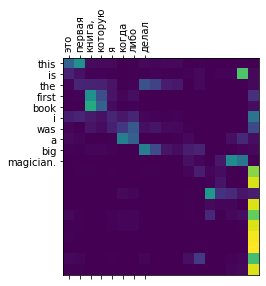

In [ ]:
plot_attention_head(in_tokens, translated_tokens, attention)

In [ ]:
def plot_attention_weights(sentence, translated_tokens, attention_heads):
  in_tokens = tf.convert_to_tensor([sentence])
  in_tokens = rus_tokenize(in_tokens)
  #in_tokens = tokenizers.pt.lookup(in_tokens)[0]
  in_tokens

  fig = plt.figure(figsize=(16, 8))

  for h, head in enumerate(attention_heads):
    ax = fig.add_subplot(2, 4, h+1)

    plot_attention_head(in_tokens, translated_tokens, head)

    ax.set_xlabel(f'Head {h+1}')

  plt.tight_layout()
  plt.show()

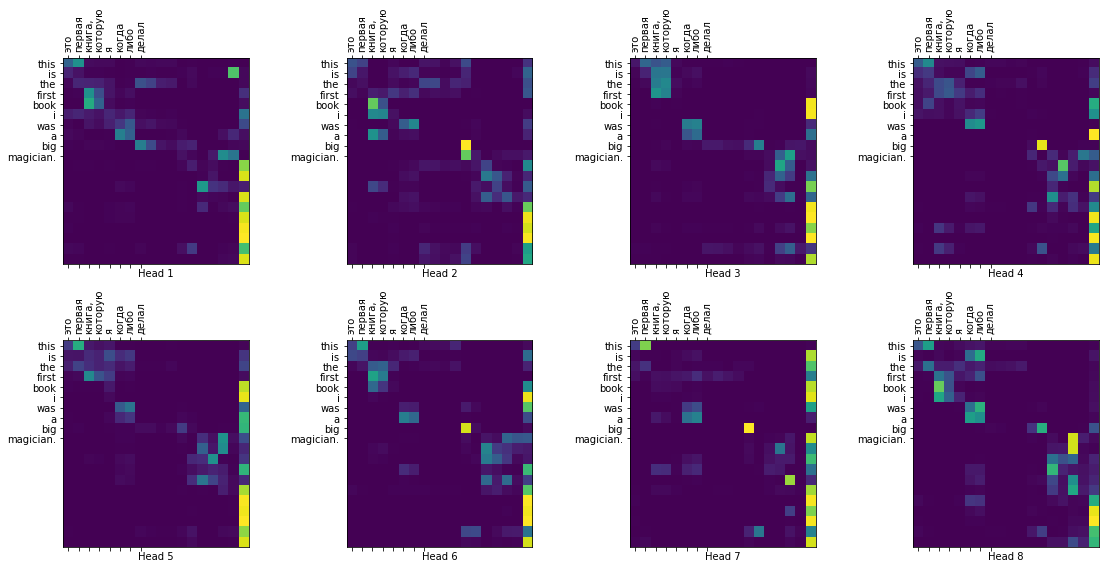

In [ ]:
plot_attention_weights(sentence, translated_tokens,
                       attention_weights['decoder_layer4_block2'][0])

Input:         : Я читал о трицератопсе в энциклопедии.
Prediction     : старт i read the same of the same конец
Ground truth   : I read about triceratops in the encyclopedia.


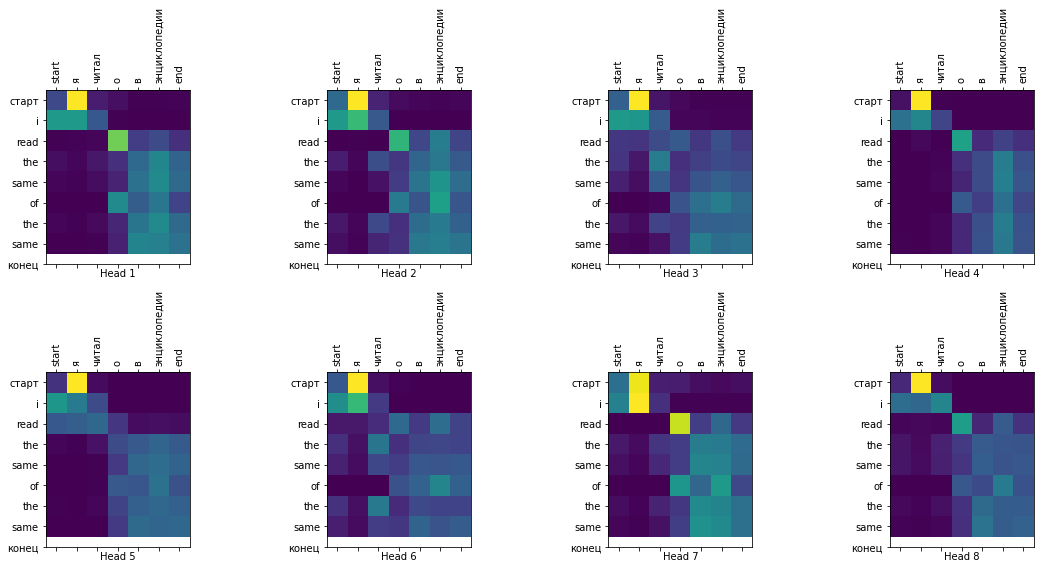

In [ ]:
sentence = "Я читал о трицератопсе в энциклопедии."
ground_truth = "I read about triceratops in the encyclopedia."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

plot_attention_weights(sentence, translated_tokens,
                       attention_weights['decoder_layer4_block2'][0])

##Экспорт готового переводчика

In [ ]:
class ExportTranslator(tf.Module):
  def __init__(self, translator):
    self.translator = translator

  @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
  def __call__(self, sentence):
    (result, 
     tokens,
     attention_weights) = self.translator(sentence, max_length=100)

    return result

In [ ]:
translator = ExportTranslator(translator)

In [ ]:
translator("este é o primeiro livro que eu fiz.").numpy()

In [ ]:
tf.saved_model.save(translator, export_dir='translator')

In [ ]:
reloaded = tf.saved_model.load('translator')

In [ ]:
reloaded("este é o primeiro livro que eu fiz.").numpy()